In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import re
import time
import datetime
import gc

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<h1>Dataset Loading</h1>

In [3]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])


/opt/conda/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

<h1>Tokenization and Encoding</h1>

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
texts = train_df.text.values
labels = train_df.label.values
test_texts = test_df.text.values
test_labels = test_df.label.values  # Corrected

# Didn't encounter any ' symbol but understood it was a suffix-like
print('Original: ', texts[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(texts[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[0])))

# Calculate maximum length
max_len = 0
for sent in texts:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

test_max_len = 0
for sent in test_texts:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    test_max_len = max(test_max_len, len(input_ids))

print('Max test sentence length: ', test_max_len)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Original:  i didnt feel humiliated
Tokenized:  ['i', 'didn', '##t', 'feel', 'humiliated']
Token IDs:  [1045, 2134, 2102, 2514, 26608]
Max sentence length:  87
Max test sentence length:  66


<h1>Encoding and Masking</h1>

In [5]:
# From encoding to dictionary, from dictionary to tensors
input_ids = []
attention_masks = []

for text in texts:
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', texts[0])
print('Token IDs:', input_ids[0])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  i didnt feel humiliated
Token IDs: tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])


<h1>Test Data Encoding</h1>

In [6]:
test_input_ids = []
test_attention_masks = []

for t_text in test_texts:
    encoded_dict = tokenizer.encode_plus(
        t_text,
        add_special_tokens=True,
        max_length=test_max_len,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

print('Original: ', test_texts[0])
print('Token IDs:', test_input_ids[0])


Original:  im feeling rather rotten so im not very ambitious right now
Token IDs: tensor([  101, 10047,  3110,  2738, 11083,  2061, 10047,  2025,  2200, 12479,
         2157,  2085,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0])


<h1>Dataset and Dataloader Creation</h1>

In [7]:
print(f"Size of test_input_ids: {test_input_ids.size()}")
print(f"Size of test_attention_masks: {test_attention_masks.size()}")
print(f"Size of test_labels: {test_labels.size()}")


Size of test_input_ids: torch.Size([2000, 66])
Size of test_attention_masks: torch.Size([2000, 66])
Size of test_labels: torch.Size([2000])


In [8]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
)

# Ensure test dataset and dataloader are created correctly
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)


12,800 training samples
3,200 validation samples


<h1>Model Setup and Training</h1>

In [19]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6,
    output_attentions=False,
    output_hidden_states=False,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<h1>Training Loop</h1>

In [20]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# to beautify accuracy output
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
seed_val = 23
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)
    # Calculate average training accuracy
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Average training accuracy: {avg_train_accuracy:.2f}")  # Print average training accuracy
    print(f"  Training epoch took: {training_time}")
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("Running Validation...")

    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
     # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print(f"  Accuracy: {avg_val_accuracy:.2f}")
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model.state_dict(), 'bert_model.pth')
        best_eval_accuracy = avg_val_accuracy
        
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Training Accur.': avg_train_accuracy,  # Record training accuracy
        'Valid. Accur.': avg_val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print("Training complete!")
print(f"Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")


======== Epoch 1 / 4 ========
Training...
  Average training loss: 0.74
  Training epoch took: 0:01:52
Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.24
  Validation took: 0:00:09
======== Epoch 2 / 4 ========
Training...
  Average training loss: 0.18
  Training epoch took: 0:01:51
Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.18
  Validation took: 0:00:09
======== Epoch 3 / 4 ========
Training...
  Average training loss: 0.11
  Training epoch took: 0:01:51
Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.15
  Validation took: 0:00:09
======== Epoch 4 / 4 ========
Training...
  Average training loss: 0.08
  Training epoch took: 0:01:51
Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.15
  Validation took: 0:00:09
Training complete!
Total training took 0:08:04 (h:mm:ss)


<h1>Model Loading and Evaluation</h1>

In [23]:
# Save the model state dictionary
torch.save(model.state_dict(), 'bert_model.pth')

# Load the saved model state dictionary
model.load_state_dict(torch.load('bert_model.pth'))
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [24]:
# Initialize empty lists for predictions and true labels
predictions = []
true_labels = []

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()

    predictions.extend(list(pred_flat))
    true_labels.extend(list(labels_flat))


In [34]:
# Import classification report from sklearn
from sklearn.metrics import classification_report


# Print classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       581
           1       0.96      0.94      0.95       695
           2       0.80      0.84      0.82       159
           3       0.93      0.91      0.92       275
           4       0.86      0.92      0.89       224
           5       0.80      0.65      0.72        66

    accuracy                           0.92      2000
   macro avg       0.88      0.87      0.88      2000
weighted avg       0.93      0.92      0.92      2000



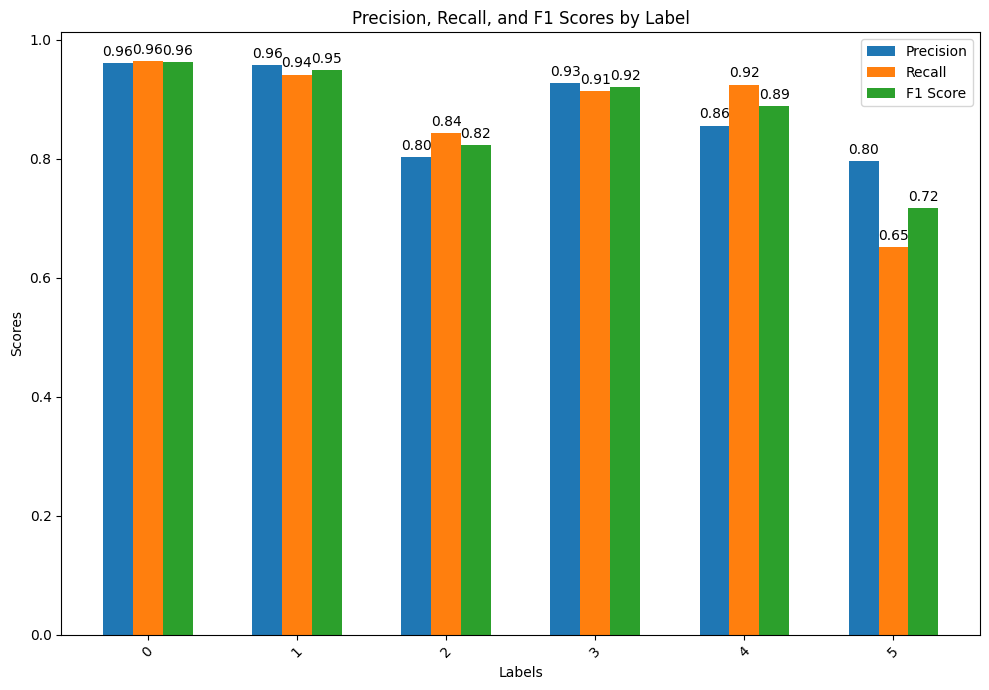

In [37]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt
import numpy as np

# Get classification report as dictionary
report = classification_report(true_labels, predictions, output_dict=True)

# Extract metrics for each label
labels = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

# Plotting the results
x = np.arange(len(labels))  # Label locations
width = 0.2  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 7))

rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Labels')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Scores by Label')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Function to add labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to the bars
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# Show plot
plt.show()
